# Optimized energy scenarios Giudicarie Esteriori

Author: Michele Urbani ([murbani@fbk.eu](mailto:murbani@fbk.eu))

In this notebook, we replicate the study in {cite:ps}`MAHBUB2016236`.

## Problem description

### Decision variables

The decision variables are:

1. **PV capacity**: the amount of installed PV capacity is 5 MW and it is
as the lower bound for the variable, whereas the calculated maximum PV capacity
is 42 MW, which is the upper bound.
2. **Heat production technologies**: individual wood, oil, LPG boilers, and
gound source heat pumps are decision variables expressed as percentages of the
total.
3. **Wood organic ranking cycle micro cogeneration** provides both thermal and
electrical power

### Constraints

The are two constraints: the first concerns the variables at points 2 and 3 of
the list above, which must sum to 1. The second constraints limits the total
wood consumption to be less than 57 GWh/year.

### Optimization objectives

There are four optimization objectives.

1. **CO$_2$ minimization**: the value of produced CO$_2$ is
``CO2-emission (corrected)`` in EnergyPLAN output.
2. **Annual cost minimization**: the annual cost is the sum of the annual
investment cost, variable operational and maintenance (O&M) cost, fixed
operational and maintenacne cost, and the variable O&M and fixed O&M costs.
3. **Load following capacity (LFC) minimization**: the LFC expresses how much
electricity production follows electrivity demand over a period (yearly in this
case).
4. **Energy system dependency (ESD) minimization** concerns the reduction of
foreign energy import.

## Problem declaration

The ``_evaluate`` method is analyzed in the following.

In [1]:
import inspect
from IPython.display import display, Markdown

from moea.models import get_model
from moea.algorithms import get_algorithm

model_name = 'Giudicarie'
algorithm_name = 'mahbub2016'

model = get_model(model_name)
algorithm = get_algorithm(algorithm_name, pop_size=150)

eval_code = inspect.getsource(model._evaluate)
display(Markdown("```python\n" + eval_code + "```"))

2025-01-16 08:48:24.895 | INFO     | moea.config:<module>:11 - PROJ_ROOT path is: C:\Users\murbani\moea


```python
    def _evaluate(self, x, out, *args, **kwargs):
        # Use pseudo-enums
        OIL = 0
        LPG = 1
        BIOMASS = 2
        CHP = 3
        HP = 4
        EC = 5

        # Sort percentages in ascending order
        sorted_perc = np.sort(x[:, 1:]).T

        percentages = np.zeros((5, len(x)))
        percentages[OIL] = sorted_perc[OIL]
        percentages[LPG] = sorted_perc[LPG] - sorted_perc[OIL]
        percentages[BIOMASS] = sorted_perc[BIOMASS] - sorted_perc[LPG]
        percentages[CHP] = sorted_perc[CHP] - sorted_perc[BIOMASS]
        percentages[HP] = 1 - sorted_perc[CHP]

        # Electric car percentage
        reducedNumberOfPetrolCars = (self.currentNumberOfPertrolCars * \
            (1 - x[:, EC])).astype(int)
        reducedNumberOfDieselCars = (self.currentNumberOfDieselCars * \
            (1 - x[:, EC])).astype(int)
        reducedPetrolDemandInGWh = \
            (reducedNumberOfPetrolCars * self.averageKMPerYearForPetrolCar * \
             self.LCVPetrol) / (self.petrolCarRunsKMperL * 1e6)
        reducedDieselDemandInGWh = \
            (reducedNumberOfDieselCars * self.averageKMPerYearForDieselCar * \
                self.LCVDiesel) / (self.DieselCarRunsKMperL * 1e6)
        elecCarRunKM = self.totalKMRunByCars - \
            (reducedNumberOfPetrolCars * self.averageKMPerYearForPetrolCar) - \
                (reducedNumberOfDieselCars * self.averageKMPerYearForDieselCar)
        elecCarElectricityDemandInGWh = elecCarRunKM * \
            self.KWhPerKMElecCar / 1e6

        oilBoilerDemand = self.totalHeatDemand * percentages[OIL] / \
            self.oilBoilerEfficiency
        LPGBoilerDemand = self.totalHeatDemand * percentages[LPG] / \
            self.ngasBoilerEfficiency
        biogasBoilerDemand = self.totalHeatDemand * percentages[BIOMASS] / \
            self.biomassBoilerEfficiency
        bioCHPDemand = self.totalHeatDemand * percentages[CHP]
        HPDemand = self.totalHeatDemand * percentages[HP]

        # Dump the input vectors to files
        for i, ind in enumerate(x):
            dump_input(
                {
                    "input_RES1_capacity": ind[0],
                    "input_fuel_Households[2]": oilBoilerDemand[i],
                    "input_fuel_Households[3]": LPGBoilerDemand[i],
                    "input_fuel_Households[4]": biogasBoilerDemand[i],
                    "input_HH_BioCHP_heat": bioCHPDemand[i],
                    "input_HH_HP_heat": HPDemand[i],
                    "input_transport_TWh": elecCarElectricityDemandInGWh[i],
                    "input_fuel_Transport[2]": reducedDieselDemandInGWh[i],
                    "input_fuel_Transport[5]": reducedPetrolDemandInGWh[i],
                    "Filnavn_transport": "CIVIS_Transport_NC.txt"
                },
                i, self.default_data)

        # Compute the objective functions
        execute_energyplan_spool([f"input{i}.txt" for i in range(len(x))])

        # Retrieve CO2 emissions and total annual costs
        z = find_values(
                ENERGYPLAN_RESULTS,
                "CO2-emission (corrected)",
                "Variable costs",
                "Fixed operation costs",
                "Annual Investment costs",
                ("Annual", "Hydro Electr."),
                ("Annual", "PV Electr."),
                ("Annual", "Wave Electr."),
                ("Annual", "Import Electr."),
                ("Annual", "Export Electr."),
                ("Annual", "HH-CHP Electr."),
                ("Annual", "HH-HP Electr."),
                ("Annual", "Electr. Demand"),
                "Ngas Consumption",
                "Oil Consumption",
                "Biomass Consumption",
                ("Annual", "Flexible Electr.")
            ).T

        # Retrieve:
        CO2 = 0  # annual CO2 emissions
        VAR_COST = 1  # annual variable costs
        FIX_COST = 2  # annual fixed costs
        INV_COST = 3  # annual investment costs
        PV = 3  # annual PV electricity
        HYDRO = 4  # annual hydropower
        WAVE = 5  # annual wave power
        IMPORT = 6  # annual import
        EXPORT = 7  # annual export
        HP = 8  # annual HP electricity
        HH_CHP = 9  # annual HH electricity CHP
        DEMAND = 10  # annual demand
        NGAS = 11  # annual natural gas
        OIL = 12  # annual oil
        BIOMASS = 13  # annual biomass
        FLEXI = 14  # annual flexible demand

        totalAdditionalCost = ((
            z[HYDRO] + z[PV] + z[HH_CHP] + z[IMPORT] - z[EXPORT]
        ) * self.addtionalCostPerGWhinKEuro).astype(int)

        # The meaning of HP changed, use directly the index 4
        capacityOfHeatPump = (
            (self.maxHeatDemandInDistribution * percentages[4] *
             self.totalHeatDemand * 1e6) / \
                (self.COP * self.sumOfAllHeatDistributions)).astype(int)

        geoBoreHoleInvestmentCost = (
            capacityOfHeatPump * self.geoBoreholeCostInKWe * self.interest
        ) / (1 - (1 + self.interest) ** -self.geoBoreHoleLifeTime)

        # See the annual inventment cost formula in EnergyPLAN manual

        # The meaning of BIOMASS changed, use directly the index 2
        newCapacityBiomassBoiler = (
            (self.totalHeatDemand * percentages[2]) * 1e6 * 1.5 /
            self.sumOfAllHeatDistributions).astype(int)

        investmentCostReductionBiomassBoiler = np.where(
            newCapacityBiomassBoiler > self.currentIndvBiomassBoilerCapacity,
            (self.currentIndvBiomassBoilerCapacity * \
                self.individualBoilerInvestmentCostInKEuro * \
                    self.interest) / \
                    (1 - (1 + self.interest) ** -self.boilerLifeTime),
            (newCapacityBiomassBoiler * \
                self.individualBoilerInvestmentCostInKEuro * \
                    self.interest) / \
                        (1 - (1 + self.interest) ** -self.boilerLifeTime)
        )

        # Since OIL has been overwritten, we use directly the index 1 for OIL
        newCapacityOilBoiler = ((self.totalHeatDemand * percentages[1]) * \
            1e6 * 1.5 / self.sumOfAllHeatDistributions).astype(int)

        investmentCostReductionOilBoiler = np.where(
            newCapacityOilBoiler > self.currentIndvOilBoilerCapacity,
            (self.currentIndvOilBoilerCapacity * \
                self.individualBoilerInvestmentCostInKEuro * \
                    self.interest) / \
                    (1 - (1 + self.interest) ** -self.boilerLifeTime),
            (newCapacityOilBoiler * \
                self.individualBoilerInvestmentCostInKEuro * \
                    self.interest) / \
                        (1 - (1 + self.interest) ** -self.boilerLifeTime)
        )

        # Since LPG has been overwritten, we use directly the index 1 for LPG
        newCapacityLPGBoiler = ((self.totalHeatDemand * percentages[1]) * \
            1e6 * 1.5 / self.sumOfAllHeatDistributions).astype(int)

        investmentCostReductionLPGBoiler = np.where(
            newCapacityLPGBoiler > self.currentIndvLPGBoilerCapacity,
            (self.currentIndvLPGBoilerCapacity * \
                self.individualBoilerInvestmentCostInKEuro * \
                    self.interest) / \
                    (1 - (1 + self.interest) ** -self.boilerLifeTime),
            (newCapacityLPGBoiler * \
                self.individualBoilerInvestmentCostInKEuro * \
                    self.interest) / \
                        (1 - (1 + self.interest) ** -self.boilerLifeTime)
        )

        reductionInvestmentCost = \
            (self.currentPVCapacity * self.PVInvestmentCostInKEuro *
             self.interest) / (1 - (1 + self.interest) ** -self.PVLifeTime) + \
            (self.currentHydroCapacity * self.hydroInvestmentCostInKEuro *
             self.interest) / \
                (1 - (1 + self.interest) ** -self.HydroLifeTime) + \
            (self.currentBiogasCapacity * self.BiogasInvestmentCostInKEuro *
             self.interest) / \
                (1 - (1 + self.interest) ** -self.BiogasLifeTime) + \
            investmentCostReductionBiomassBoiler + \
            investmentCostReductionOilBoiler + \
            investmentCostReductionLPGBoiler

        # Compute the real investment cost
        realInvestmentCost = z[INV_COST] - \
            reductionInvestmentCost + geoBoreHoleInvestmentCost

        # Electric car related costs
        totalNumberOfELectricCars = (
            self.currentNumberOfPertrolCars + self.currentNumberOfDieselCars -
            reducedNumberOfPetrolCars - reducedNumberOfDieselCars).astype(int)

        totalInvestmentCostForElectricCars = totalNumberOfELectricCars * \
            self.costOfElectricCarInKeuro * self.interest / \
                (1 - (1 + self.interest) ** -self.electricCarLifeTime)

        totalFixOperationalAndInvestmentCostForElectricCars = \
            totalNumberOfELectricCars * self.costOfElectricCarInKeuro * \
                self.electricCarOperationalAndMaintanenceCost

        # Compute the actual annual cost, which is the third objective
        actualAnnualCost = z[VAR_COST] + z[FIX_COST] + \
            realInvestmentCost + totalAdditionalCost + \
            totalInvestmentCostForElectricCars + \
                totalFixOperationalAndInvestmentCostForElectricCars

        # Load followint capacity
        LFS = (z[IMPORT] + z[EXPORT]) / (z[DEMAND] + z[FLEXI] + z[HP])

        totalPEForElectricity = z[PV] * self.PVPEF + z[HYDRO] * self.HYPEF + \
            z[WAVE] * self.BioGasPEF + z[BIOMASS] * self.BiomassPEF

        totalLocalElecProduction = z[PV] + z[HYDRO] + z[WAVE] + z[HH_CHP]

        PEFLocalElec = totalPEForElectricity / totalLocalElecProduction

        totalPEConsumption = (totalLocalElecProduction - z[EXPORT]) * \
            PEFLocalElec + z[IMPORT] * self.PEFImport + z[BIOMASS] + \
                z[OIL] + z[NGAS] + (self.totalHeatDemand * percentages[4]) * \
                    (1 - 1 / self.COP)

        ESD = (z[IMPORT] * self.PEFImport + z[OIL] + z[NGAS]) / \
            totalPEConsumption

        out["F"] = np.column_stack([
            z[CO2], actualAnnualCost, LFS, ESD
        ])

        ##########################
        # Evaluate the constraints
        ##########################
        # There is only one constraint to limit the consumption of biomass
        out["G"] = np.column_stack([56.87 - z[BIOMASS]])
```

In [2]:
from pymoo.optimize import minimize

res = minimize(
    model,
    algorithm,
    ('n_gen', 200),
    seed=1234,
    verbose=True,
)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      150 |      1 |  0.000000E+00 |  3.226547E+01 |             - |             -
     2 |      300 |      3 |  0.000000E+00 |  2.179033E+01 |  1.0000000000 |         ideal
     3 |      450 |      3 |  0.000000E+00 |  1.862053E+01 |  0.000000E+00 |             f
     4 |      600 |      3 |  0.000000E+00 |  1.638120E+01 |  0.000000E+00 |             f
     5 |      750 |      3 |  0.000000E+00 |  1.500240E+01 |  0.000000E+00 |             f
     6 |      900 |      3 |  0.000000E+00 |  1.417133E+01 |  0.000000E+00 |             f
     7 |     1050 |      3 |  0.000000E+00 |  1.289420E+01 |  0.000000E+00 |             f
     8 |     1200 |      3 |  0.000000E+00 |  1.232053E+01 |  0.000000E+00 |             f
     9 |     1350 |      3 |  0.000000E+00 |  1.167460E+01 |  0.000000E+00 |             f
    10 |     1500 |      3 |  0.000000E+00 |  1.109567E+01 |  0.000000E+00 |             f

## Results analysis

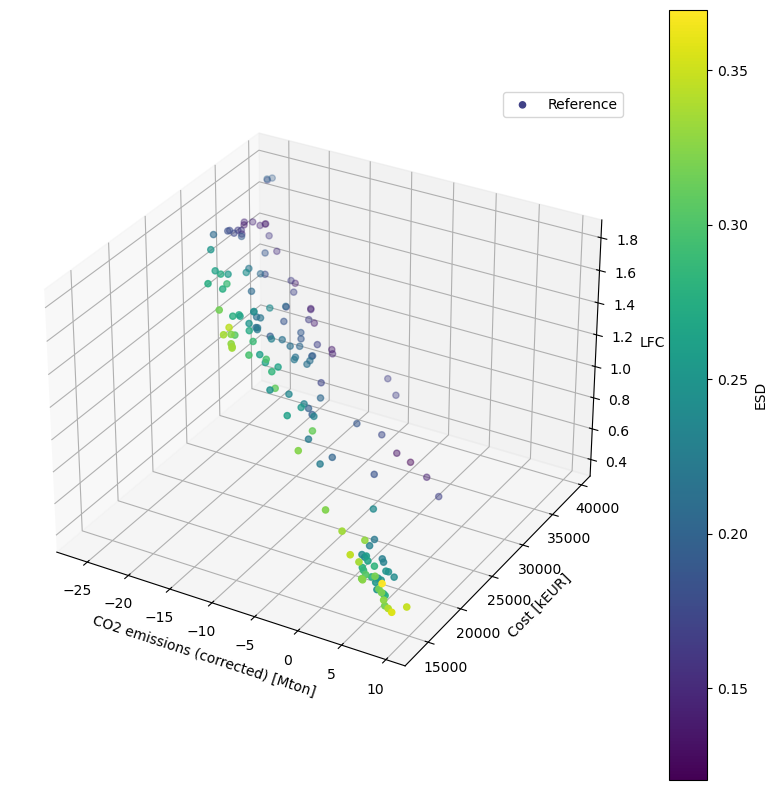

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load reference data from the paper, no index column and space separated
ref = pd.read_csv('giudicarie-reference.csv', sep=' ', header=None,
                  names=['CO2 emissions (corrected) [Mton]', 'Cost [kEUR]',
                         'LFC', 'ESD'],
                  index_col=False)

# 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Use a colormap to set the marker colors
sc = ax.scatter(
    ref['CO2 emissions (corrected) [Mton]'],
    ref['Cost [kEUR]'],
    ref['LFC'],
    c=ref['ESD'],
    cmap='viridis',
    label='Reference'
)

# Add color bar which maps the colors to the ESD values
cbar = fig.colorbar(sc)
cbar.set_label('ESD')

ax.set_xlabel('CO2 emissions (corrected) [Mton]')
ax.set_ylabel('Cost [kEUR]')
ax.set_zlabel('LFC')
plt.legend()
plt.show()


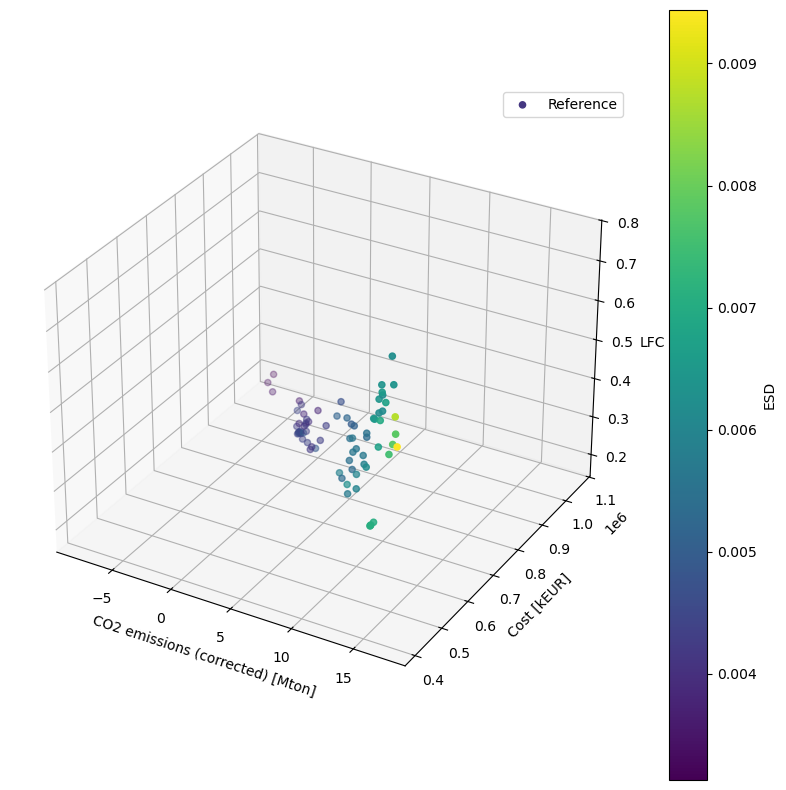

In [4]:
# 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Cast results to DataFrame
df = pd.DataFrame(
    res.F,
    columns=[
        'CO2 emissions (corrected) [Mton]',
        'Cost [kEUR]',
        'LFC',
        'ESD'
    ]
)

# Use a colormap to set the marker colors
sc = ax.scatter(
    df['CO2 emissions (corrected) [Mton]'],
    df['Cost [kEUR]'],
    df['LFC'],
    c=df['ESD'],
    cmap='viridis',
    label='Reference'
)

# Add color bar which maps the colors to the ESD values
cbar = fig.colorbar(sc)
cbar.set_label('ESD')

ax.set_xlabel('CO2 emissions (corrected) [Mton]')
ax.set_ylabel('Cost [kEUR]')
ax.set_zlabel('LFC')
plt.legend()
plt.show()


### Convergence analysis

The results of the paper {cite:t}`MAHBUB2016140` are used as reference to
measure the quality of the solution. We implement the Inverted Generational
Distance (IGD) {cite:t}`COELLOCOELLO2004688` to quantify the distance from any
point in the set of solutions $Z$ to the closest point in the set of
reference solutions $A$.

$$
IGD(A) = \frac{1}{|Z|} \left( \sum_{i=1}^{|Z|} \hat{d}_i ^{\,p} \right) ^{1/p}
$$

where $\hat{d}_i$ represents the Euclidean distance ($p=2$) from $z_i$ to its
nearest reference point in $A$.

The lower the value of the IGD, the closer the set $A$ to the reference set
$Z$.

In [5]:
from pymoo.indicators.igd import IGD

ind = IGD(ref.values)
print("IGD", ind(res.F))

IGD 385505.89464256226


## References

```{bibliography}
:style: unsrt
```